In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torchvision.transforms import RandomHorizontalFlip

from models import U_Net_big
from RectifiedFlow import RectifiedFlow_Unet, train

from util import load_Cifar10, show_samples, show_trajectories

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 512
train_dataset, test_dataset, train_dataloader, test_dataloader, classes = load_Cifar10(batch_size, [1])
input_shape = (batch_size, 4, 32, 32)

def get_samples(shape, device):
    return torch.randn(shape, device=device)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([5000, 3, 32, 32])


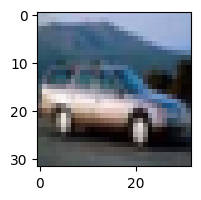

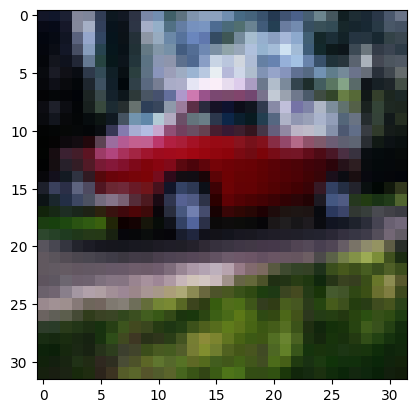

In [167]:
data = torch.tensor(train_dataset.data).permute([0,3,1,2])
print(data.shape)
plt.figure(figsize=(2,2))
plt.imshow(data[0].permute([1,2,0]))
plt.show()
hflipper = RandomHorizontalFlip(p=0.5)
transformed_imgs = hflipper(data)
plt.imshow(transformed_imgs[89].permute([1,2,0]))
plt.show()

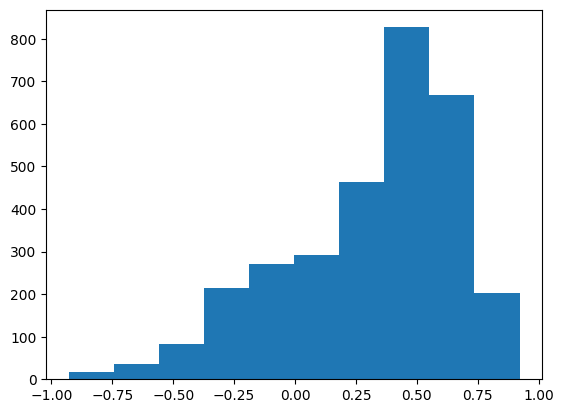

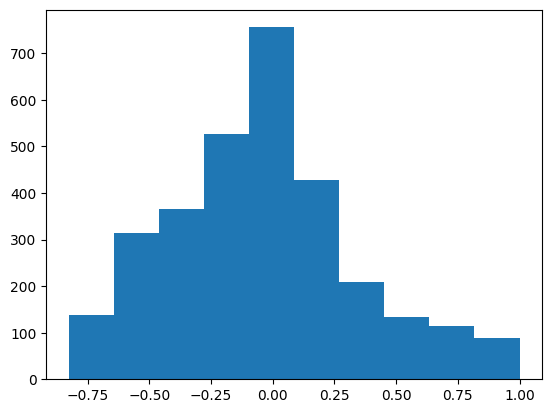

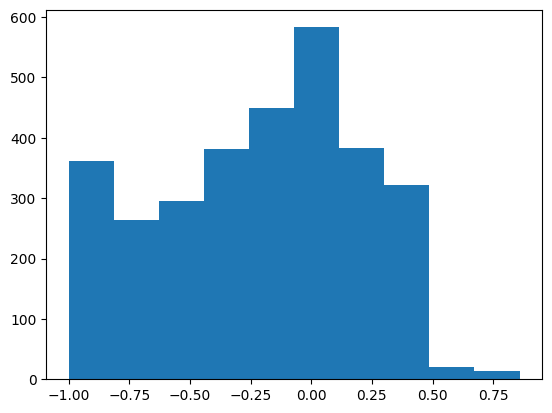

In [5]:
for batch in train_dataloader:
    plt.hist(batch[0][0].flatten().cpu().numpy())
    plt.show()
    plt.hist(batch[0][1].flatten().cpu().numpy())
    plt.show()
    plt.hist(batch[0][2].flatten().cpu().numpy())
    plt.show()
    break

In [5]:
v_model_1 = U_Net_big(input_shape=input_shape, output_channels=3, device=device)
rectified_flow_1 = RectifiedFlow_Unet(v_model_1, device)

In [6]:
optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=2e-4, weight_decay=10e-5)
scheduler_1 = None #optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.9, patience=120, verbose=True)

In [187]:
optimizer_1.__setattr__("lr", 5e-5)

In [208]:
scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.9, patience=300, verbose=True)

Epoch 00310: reducing learning rate of group 0 to 1.8000e-04.
Epoch 00992: reducing learning rate of group 0 to 1.6200e-04.
Epoch 01529: reducing learning rate of group 0 to 1.4580e-04.
Epoch 01830: reducing learning rate of group 0 to 1.3122e-04.
Epoch 02131: reducing learning rate of group 0 to 1.1810e-04.
Epoch 02432: reducing learning rate of group 0 to 1.0629e-04.
Epoch 03018: reducing learning rate of group 0 to 9.5659e-05.
Epoch 03319: reducing learning rate of group 0 to 8.6093e-05.
Epoch 03620: reducing learning rate of group 0 to 7.7484e-05.
Epoch 03921: reducing learning rate of group 0 to 6.9736e-05.
Epoch 04222: reducing learning rate of group 0 to 6.2762e-05.
Epoch 04523: reducing learning rate of group 0 to 5.6486e-05.
Epoch 04824: reducing learning rate of group 0 to 5.0837e-05.
Epoch 05125: reducing learning rate of group 0 to 4.5754e-05.
Epoch 05431: reducing learning rate of group 0 to 4.1178e-05.
Epoch 05732: reducing learning rate of group 0 to 3.7060e-05.
Epoch 06

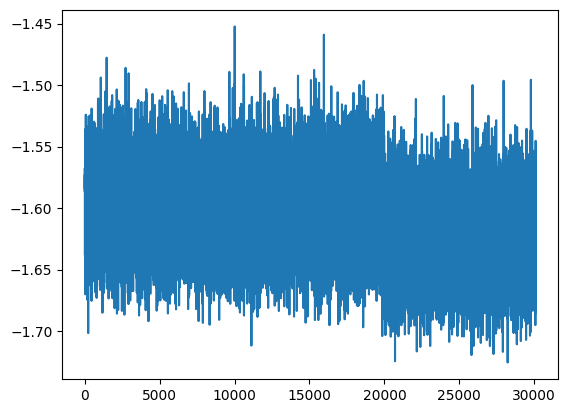

In [209]:
rectified_flow_1 = train(rectified_flow_1, False, optimizer_1, scheduler_1, train_dataloader, get_samples, device, epochs=700, noise_factor=0.005, flip=True)
plt.plot(np.log(rectified_flow_1.loss_curve[100000:]))
plt.show()

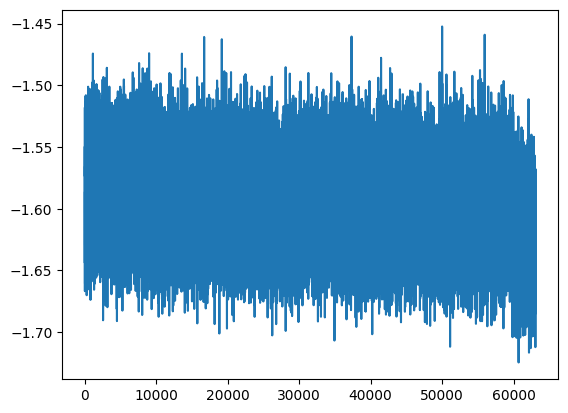

In [207]:
plt.plot(np.log(rectified_flow_1.loss_curve[60000:]))
plt.show()

In [553]:
torch.save(rectified_flow_1, "./models/CIFAR10/cifar10_car.pth")

In [4]:
rectified_flow_1 = torch.load("./models/CIFAR10/cifar10_car.pth")

In [168]:
def get_samples(shape, device):
    return torch.randn(shape, device=device)

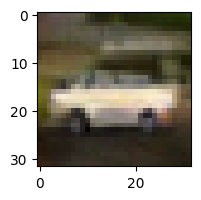

In [5]:
rectified_flow_1.v_model.eval()
img_init = torch.randn(1,3,32,32).to(device) * 0.9
img = rectified_flow_1.sample_ode(img_init, 100)

# print(img[-1])

min = torch.min(img[-1][0])
img[-1][0] = img[-1][0] - min
max = torch.max(img[-1][0])
img[-1][0] = img[-1][0] / max

plt.figure(figsize=(2,2))
plt.imshow(img[-1][0].permute(1,2,0).detach().cpu().numpy())
plt.show()

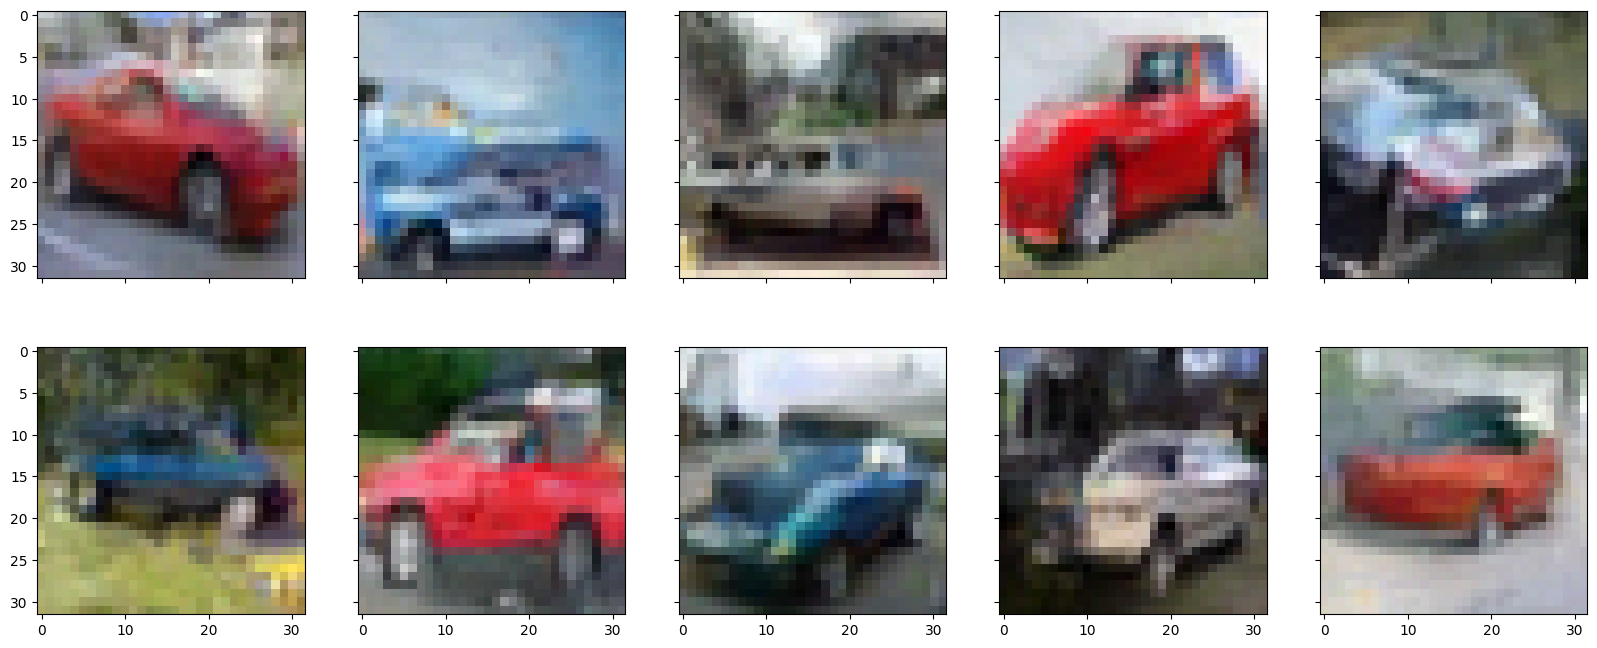

In [11]:
show_samples(rectified_flow_1, get_samples, columns=5, rows=2, channels=3, img_size=32, num_steps=100, device=device)

In [327]:
show_trajectories(rectified_flow_1, get_samples, img_size=32, num_steps=100, device=device)

RuntimeError: Given groups=1, weight of size [64, 4, 3, 3], expected input[20, 2, 32, 32] to have 4 channels, but got 2 channels instead

#### Reflow

In [22]:
samples_init = torch.randn(2000,1,32,32).to(device) / 3 # do this sampeling in batches ?
flow_1 = rectified_flow_1.sample_ode(samples_init, 100)

RuntimeError: CUDA out of memory. Tried to allocate 500.00 MiB (GPU 0; 7.79 GiB total capacity; 4.95 GiB already allocated; 84.75 MiB free; 6.17 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
v_model_2 = U_Net(input_shape=input_shape, output_channels=1, initial_lr=5e-3, momentum=0.9, weight_decay=0.0)
rectified_flow_2 = RectifiedFlow_Unet(v_model_2, device)

In [ ]:
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)
# optim.beta1 = 0.9
# optim.eps = 1e-8
#optimizer_1 = torch.optim.SGD(rectified_flow_1.v_model.parameters(), lr=5e-3, momentum=0.99)
scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, factor=0.8, patience=80, verbose=True)

In [ ]:
rectified_flow_2 = train_rectified_flow_Unet(rectified_flow_2, optimizer_2, scheduler_2, train_dataloader, device, epochs=60)

Epoch 00551: reducing learning rate of group 0 to 4.0000e-03.
Epoch 00652: reducing learning rate of group 0 to 3.2000e-03.
Epoch 00763: reducing learning rate of group 0 to 2.5600e-03.
Epoch 00880: reducing learning rate of group 0 to 2.0480e-03.
Epoch 00961: reducing learning rate of group 0 to 1.6384e-03.
Epoch 01042: reducing learning rate of group 0 to 1.3107e-03.
Epoch 01123: reducing learning rate of group 0 to 1.0486e-03.
Epoch 01278: reducing learning rate of group 0 to 8.3886e-04.
Epoch 01359: reducing learning rate of group 0 to 6.7109e-04.
Epoch 01440: reducing learning rate of group 0 to 5.3687e-04.
Epoch 01521: reducing learning rate of group 0 to 4.2950e-04.
Epoch 01602: reducing learning rate of group 0 to 3.4360e-04.
Epoch 01683: reducing learning rate of group 0 to 2.7488e-04.
Epoch 01764: reducing learning rate of group 0 to 2.1990e-04.
Epoch 01930: reducing learning rate of group 0 to 1.7592e-04.
Epoch 02011: reducing learning rate of group 0 to 1.4074e-04.
Epoch 02

In [ ]:
torch.save(rectified_flow_2, "./models/MNIST_newest_ref1.pth")

In [ ]:
rectified_flow_2 = torch.load("./models/MNIST_newest_ref1.pth")

tensor([[[[-0.9930, -1.0088, -1.0064,  ..., -1.0125, -1.0055, -0.9762],
          [-0.9936, -0.9874, -0.9879,  ..., -0.9942, -0.9839, -1.0150],
          [-0.9848, -0.9936, -0.9995,  ..., -0.9833, -1.0040, -0.9976],
          ...,
          [-0.9899, -1.0035, -1.0079,  ..., -1.0005, -0.9994, -0.9871],
          [-0.9933, -1.0009, -1.0023,  ..., -0.9963, -0.9966, -0.9948],
          [-0.9997, -1.0072, -1.0046,  ..., -0.9992, -0.9983, -0.9899]]],


        [[[-0.9801, -1.0077, -1.0098,  ..., -0.9986, -0.9884, -0.9866],
          [-0.9902, -0.9904, -1.0030,  ..., -1.0046, -0.9851, -0.9800],
          [-0.9845, -0.9931, -0.9984,  ..., -1.0118, -0.9973, -0.9819],
          ...,
          [-0.9918, -1.0022, -0.9894,  ..., -1.0016, -1.0048, -0.9975],
          [-0.9836, -0.9842, -0.9955,  ..., -1.0058, -1.0158, -0.9897],
          [-0.9819, -0.9891, -1.0031,  ..., -0.9978, -1.0025, -0.9883]]],


        [[[-0.9782, -1.0020, -0.9904,  ..., -1.0117, -0.9884, -0.9851],
          [-0.9910, -1.013

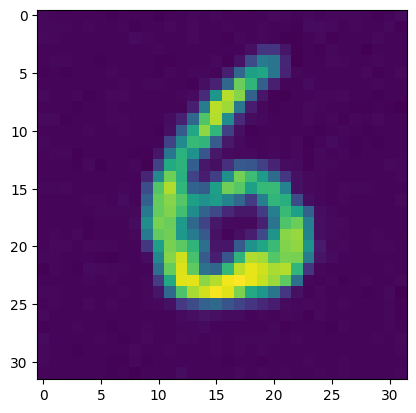

In [ ]:
rectified_flow_2.v_model.eval()
img_init = torch.randn(20,1,32,32).to(device) / 3

img = rectified_flow_2.sample_ode(img_init, 3)

print(img[-1])

plt.imshow(img[-1][0, 0].detach().cpu().numpy())
plt.show()

[]

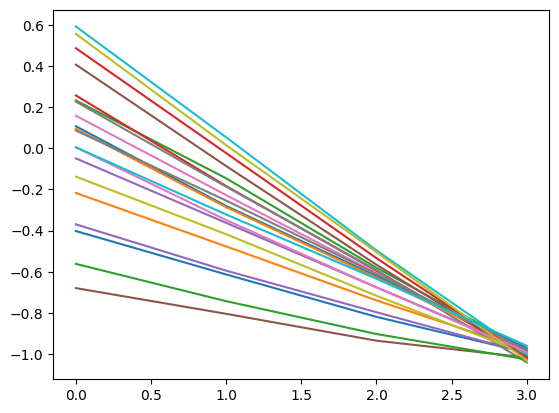

In [ ]:
s = torch.zeros(20,len(img),1,32,32)
for i in range(len(img)):
    s[:,i] = img[i]
for i in range(20):
    plt.plot(s[i,:,0,0,0].cpu().numpy())
plt.plot()

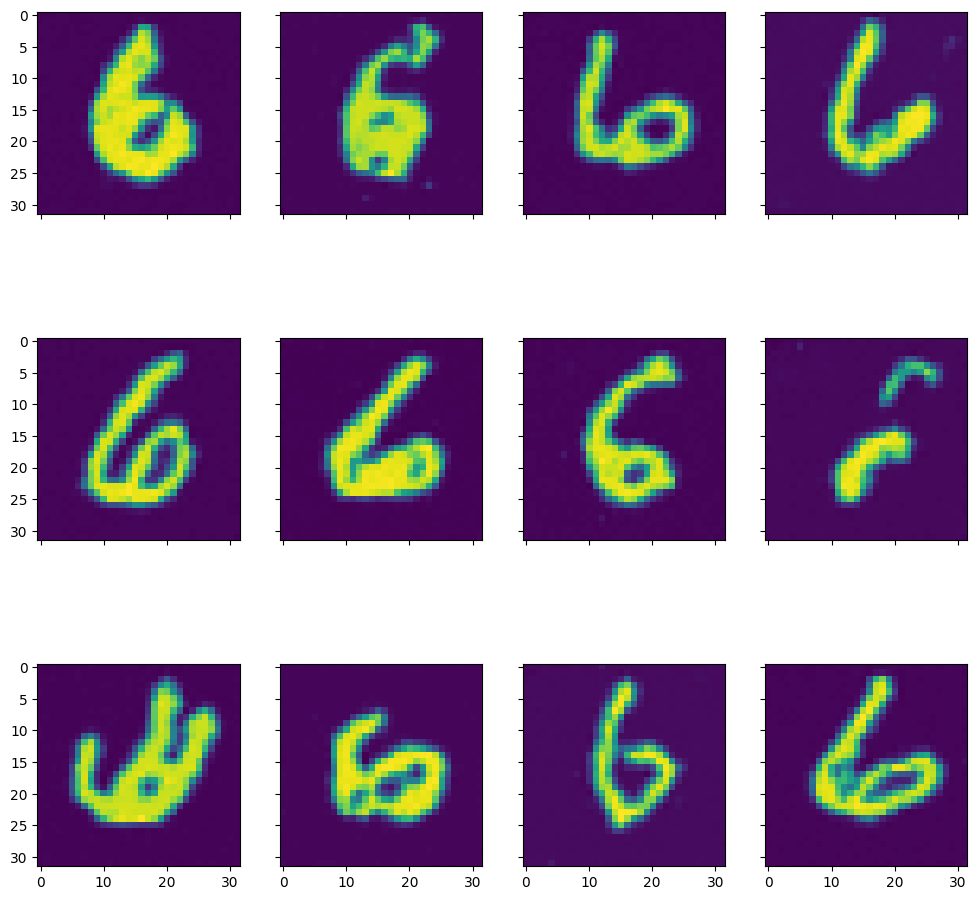

In [ ]:
rows = 3
columns = 4
size = (12, 12)
fig, ax = plt.subplots(rows, columns, figsize=(size), sharex=True, sharey=True)

for row in range(rows):
    for column in range(columns):
        img_init = torch.randn(1,1,32,32).to(device) / 3

        img = rectified_flow_2.sample_ode(img_init, 100)[-1][0,0].detach().cpu().numpy()
        ax[row, column].imshow(img)

plt.show()

In [ ]:
def show_trajectories(rectified_flow):
    rectified